In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load and preprocess the data
data = pd.read_csv('cleaned_train_bilstm.csv')

In [6]:
# Selecting only numeric columns and filling missing values
data_numeric = data.select_dtypes(include=[np.number])
data_numeric = data_numeric.fillna(data_numeric.mean())

In [8]:
# Define features (X) and target (y); assuming 'review/overall' as the target
threshold = 3.5  # Example threshold for binary classification
X = data_numeric.drop(columns=['review/overall'], errors='ignore')
y = data_numeric['review/overall'] > threshold  # Binary conversion based on threshold


In [10]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Reshape data for LSTM (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [16]:
# Model Building with Early Stopping
model = Sequential([
    LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

C:\Users\dattm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Compile and fit with early stopping
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, 
                    validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8057 - loss: 0.4250 - val_accuracy: 0.8313 - val_loss: 0.4417
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8420 - loss: 0.3685 - val_accuracy: 0.8460 - val_loss: 0.3664
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8378 - loss: 0.3737 - val_accuracy: 0.8430 - val_loss: 0.3662
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8427 - loss: 0.3687 - val_accuracy: 0.8453 - val_loss: 0.3630
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8356 - loss: 0.3723 - val_accuracy: 0.8435 - val_loss: 0.3607
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8465 - loss: 0.3626 - val_accuracy: 0.8450 - val_loss: 0.3626
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8452 - loss: 0.3656 - val_accuracy: 0.8438 - val_loss: 0.3620
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8420 - loss: 0.3605 - val_accuracy: 

In [19]:
# Evaluation and Predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)  # Binary classification with threshold 0.5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [20]:
# Confusion Matrix and Metrics
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"TNR: {tnr:.2f}, TPR: {tpr:.2f}, FPR: {fpr:.2f}, FNR: {fnr:.2f}")


Accuracy: 0.85
F1 Score: 0.89
TNR: 0.73, TPR: 0.92, FPR: 0.27, FNR: 0.08


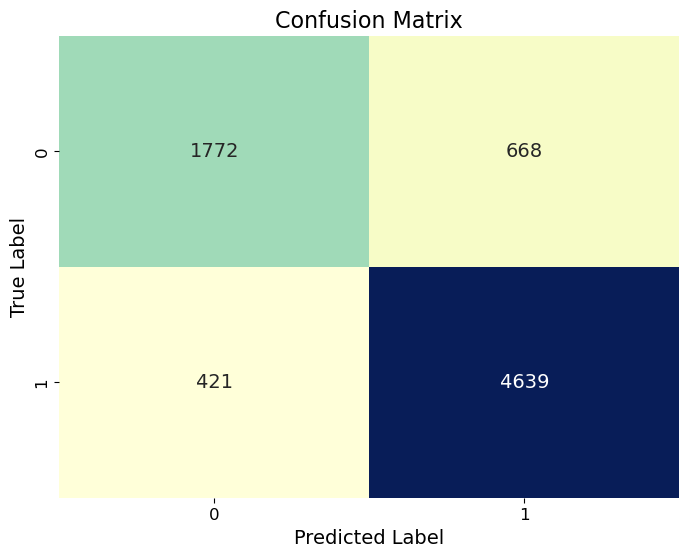

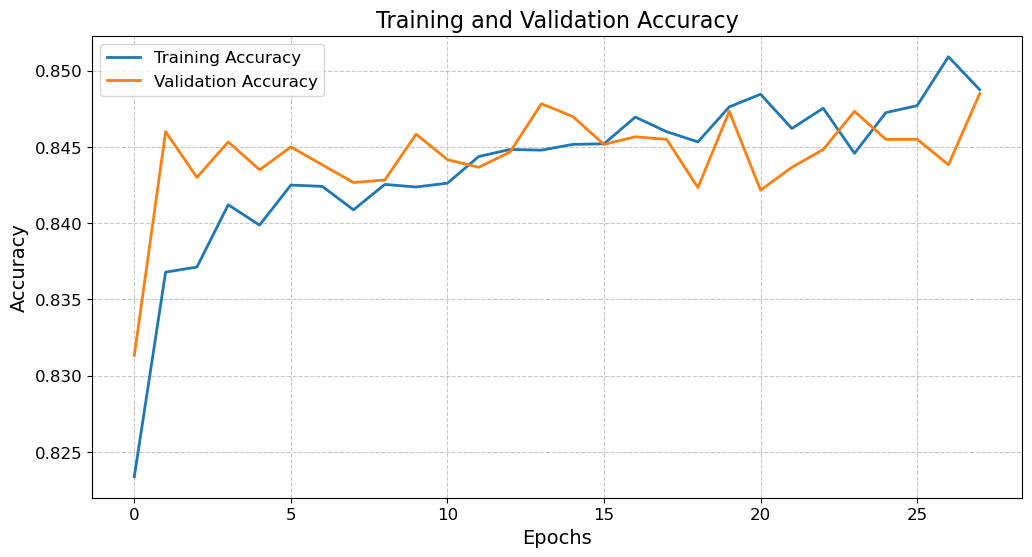

In [24]:
# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False, annot_kws={"size": 14})
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Training History Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', linewidth=2)
plt.title("Training and Validation Accuracy", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()